In [1]:
%matplotlib inline
import torch as t
from torchvision import transforms 
import random


def image_transforms(size=224):
    fr_transforms = transforms.Compose([
                        transforms.Resize(size),
                        transforms.RandomCrop(224),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomVerticalFlip(),
                        transforms.RandomRotation(45),
                        transforms.ColorJitter(brightness=0.05, contrast=0.1, saturation=0.3, hue=0.2),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
                    ])
    return fr_transforms

def enhance_transforms():
    possibility = random.randint(0, 19)
    if possibility % 20 ==0:#0.5%概率不发生变化,相当于数据集扩容20倍
        output_transforms = transforms.Compose([
                                    transforms.Resize(224),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))])
        return output_transforms
    else:
        possibility2 = random.randint(0, 3)
        if possibility2%5==0:#20%概率发生不同比例放缩
            return image_transforms(224)
        elif possibility2%5==1:
            return image_transforms(245)#面积放大1.2倍
        elif possibility2%5==2:
            return image_transforms(274)#面积放大1.5倍
        elif possibility2%5==3:
            return image_transforms(316)#面积放大2倍
    

def transform_standard():
    output_transforms = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
        ])
    return output_transforms
    

In [2]:
import torch.nn as nn



def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=False)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
 
    def forward(self, x):
        residual = x
        out = self.relu(x)
 
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
 
        if self.downsample is not None:
            residual = self.downsample(x)
 
        out = out + residual
        out = self.relu(out)
 
        return out


class Bottleneck(nn.Module):
    expansion = 4
 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=False)
        self.downsample = downsample
        self.stride = stride
 

    def forward(self, x):
        residual = x
 
        out = self.relu(x)
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
 
        out = self.conv3(out)
        out = self.bn3(out)
 
        if self.downsample is not None:
            residual = self.downsample(x)
 
        out = out + residual
        out = self.relu(out)
 
        return out

In [3]:
import re
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import moxing as mox
mox.file.shift('os', 'mox')

class DataClassify(Dataset):
    def __init__(self, root, transforms=None, mode=None):
        #存放图像地址
        self.imgs = [x.path for x in mox.file.scan_dir(root) if
            x.name.endswith(".jpg")]
        self.labels = [y.path for y in mox.file.scan_dir(root) if
            y.name.endswith(".txt")]
        self.transforms = transforms
        
    def __getitem__(self, index):
        #读取图像数据并返回
        img_path = self.imgs[index]
        label = int(re.sub('\D','',mox.file.read(self.labels[index])[-4:]))
        data = Image.open(img_path)
        if self.transforms:
            data = self.transforms(data)
        return data, label
    
    def __len__(self):
        return len(self.imgs)


def ListToTensor(lister):
    nparr = np.asarray(lister)
    tens = t.from_numpy(nparr)
    return tens

INFO:root:Using MoXing-v1.13.0-de803ac9
INFO:root:Using OBS-Python-SDK-3.1.2


In [4]:
#coefficient = 5#超参数，学习率衰减系数，与模型有关，需要调参

def dloss(loss_list, lr=0.001, coefficient=5, init_lr=0.001):
	if len(loss_list) <=2:
		return init_lr#超参数,初始学习率，与训练样本集有关，与模型关系较小，确定训练集后即可固定
	if (loss_list[-2] - loss_list[-1])/loss_list[-2] > 0.02:
		return init_lr
	return lr/coefficient


In [5]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import moxing as mox
mox.file.shift('os', 'mox')

def curve_draw(train_loss_list, train_accurate_list, test_accurate_list, log_dir, version):
    x1 = range(0, len(train_loss_list))
    x2 = range(0, len(train_accurate_list))
    x3 = range(0, len(test_accurate_list))
    y1 = train_loss_list
    y2 = train_accurate_list
    y3 = test_accurate_list
    plt.subplot(3, 1, 1)
    plt.plot(x1, y1, 'o-')
    plt.xlabel('epochs')
    plt.subplot(3, 1, 2)
    plt.plot(x2, y2, '*-')
    plt.xlabel('epochs')
    plt.subplot(3, 1, 3)
    plt.plot(x3, y3, 'x-')
    plt.xlabel('epochs')
    #plt.savefig(log_dir + 'result' + version + '.png')
    train_loss_list_path = log_dir + "train_loss" + version + '.csv'
    train_accurate_list_path = log_dir + "train_accurate" + version + '.csv'
    test_accurate_list_path = log_dir + "test_accurate" + version + '.csv'
    train_loss_list_csv = pd.DataFrame(train_loss_list)
    train_accurate_list_csv = pd.DataFrame(train_accurate_list)
    test_accurate_list_csv = pd.DataFrame(test_accurate_list)

    with mox.file.File(train_loss_list_path,"w") as c1:
        train_loss_list_csv.to_csv(c1)
    with mox.file.File(train_accurate_list_path,"w") as c2:
        train_accurate_list_csv.to_csv(c2)
    with mox.file.File(test_accurate_list_path,"w") as c3:
        test_accurate_list_csv.to_csv(c3)


In [6]:
import torch.nn as nn

class ResNet(nn.Module):
 
	def __init__(self, block, layers, num_classes=1000):
		self.inplanes = 64
		super(ResNet, self).__init__()
		self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
							   bias=False)
		self.bn1 = nn.BatchNorm2d(64)
		self.relu = nn.ReLU(inplace=False)
		self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
		self.layer1 = self._make_layer(block, 64, layers[0])
		self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
		self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
		self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
		self.avgpool = nn.AvgPool2d(7, stride=1)
		self.fc = nn.Linear(512 * block.expansion, num_classes)
 
		for m in self.modules():
			if isinstance(m, nn.Conv2d):
				nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
			elif isinstance(m, nn.BatchNorm2d):
				nn.init.constant_(m.weight, 1)
				nn.init.constant_(m.bias, 0)
 
	def _make_layer(self, block, planes, blocks, stride=1):
		downsample = None
		if stride != 1 or self.inplanes != planes * block.expansion:
			downsample = nn.Sequential(
				nn.Conv2d(self.inplanes, planes * block.expansion,
						  kernel_size=1, stride=stride, bias=False),
				nn.BatchNorm2d(planes * block.expansion),
			)
 
		layers = []
		layers.append(block(self.inplanes, planes, stride, downsample))
		self.inplanes = planes * block.expansion
		for i in range(1, blocks):
			layers.append(block(self.inplanes, planes))
 
		return nn.Sequential(*layers)
 
	def forward(self, x):
		x = self.relu(x)
		x = self.conv1(x)
		x = self.bn1(x)
		x = self.relu(x)
		x = self.maxpool(x)
 
		x = self.layer1(x)
		x = self.layer2(x)
		x = self.layer3(x)
		x = self.layer4(x)
 
		x = self.avgpool(x)
		x = x.view(x.size(0), -1)
		x = self.fc(x)
 
		return x

		
def resnet18(pretrained=False, **kwargs):
	"""Constructs a ResNet-18 model.
	Args:
		pretrained (bool): If True, returns a model pre-trained on ImageNet
	"""
	model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
	if pretrained:
		model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
	return model
 
 
def resnet34(pretrained=False, **kwargs):
	"""Constructs a ResNet-34 model.
	Args:
		pretrained (bool): If True, returns a model pre-trained on ImageNet
	"""
	model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
	if pretrained:
		model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
	return model
 
 
def resnet50(pretrained=False, **kwargs):
	"""Constructs a ResNet-50 model.
	Args:
		pretrained (bool): If True, returns a model pre-trained on ImageNet
	"""
	model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
	if pretrained:
		model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
	return model
 
 
def resnet101(pretrained=False, **kwargs):
	"""Constructs a ResNet-101 model.
	Args:
		pretrained (bool): If True, returns a model pre-trained on ImageNet
	"""
	model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
	if pretrained:
		model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
	return model
 
 
def resnet152(pretrained=False, **kwargs):
	"""Constructs a ResNet-152 model.
	Args:
		pretrained (bool): If True, returns a model pre-trained on ImageNet
	"""
	model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
	if pretrained:
		model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
	return model

In [7]:
import torch as t
from torch.autograd import Variable

def evaluate(model, data_loader_test):
	model.eval()
	correct = 0.0
	run_correct = 0.0
	for data in iter(data_loader_test):
		X_test, X_label = data
		label = []
		for la in X_label:
			label.append(la)
		label = ListToTensor(label)
		X_test = Variable(X_test)
		X_label = Variable(label)
		with t.no_grad():
			outputs = model(X_test)
			_, pred = t.max(F.softmax(outputs, dim=1).data, 1)
			run_correct += (pred == X_label.data).sum()
			corr = (1.*run_correct).item()
	return corr

In [10]:
import torch as t
from torch.nn import functional as F
from torch.autograd import Variable

def train_once(data_loader_train, net, optimizer, cost):
	run_loss = 0.0
	run_correct = 0.0

	for data in iter(data_loader_train):
		X_train, X_label = data
		label = []
		for la in X_label:
			label.append(la)
		label = ListToTensor(label)

		X_train = Variable(X_train)
		X_label = Variable(label)
		optimizer.zero_grad()
		outputs = net(X_train)

		_, pred = t.max(F.softmax(outputs, dim=1).data, 1)
		loss = cost(outputs, X_label)
		run_loss += loss.data
		run_loss = run_loss.item()

		loss.backward()
		optimizer.step()
		run_correct += (pred == X_label.data).sum()
		corr = (1.*run_correct).item()
	return run_loss, corr


def train(epochs=120,
		init_lr=0.001,
		lr_coefficient=5,
		weight_decay = 1e-8,
		model_num=1,
		batch_size=64,
		train_dir='s3://classifier-gar/train_try/',
		test_dir='s3://classifier-gar/test_try/',
		log_dir='s3://classifier-gar/log/',#用之前记着写默认路径
		version = 'V0_0_0'):

	#loading_data
	print("data loading...\n")
	transform = enhance_transforms()
	transform_std = transform_standard()
	trainset = DataClassify(train_dir, transforms=transform)
	testset = DataClassify(test_dir, transforms=transform_std)
	total_train = len(trainset)
	total_test = len(testset)
	data_loader_train = t.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
	data_loader_test = t.utils.data.DataLoader(dataset=testset, batch_size=batch_size, shuffle=False)
	print("data loading complete\n")

	##################################
	#TO DO
	##################################
	if model_num==0:#写不同模型的分支
		exit(0)
	else:
		net = resnet18()
	##################################

	cost = t.nn.CrossEntropyLoss()
	train_loss_list = []
	train_accurate_list = []
	test_loss_list = []
	test_accurate_list = []
	
	for epoch in range(epochs):
		print("epoch " + str(epoch+1) + " start training...\n")

		net.train()

		learning_rate = dloss(train_loss_list, init_lr, lr_coefficient, init_lr)
		optimizer = t.optim.Adam(list(net.parameters()), lr=learning_rate, weight_decay=weight_decay)

		run_loss, corr = train_once(data_loader_train,net, optimizer, cost)
		train_loss_list.append(run_loss/total_train)
		train_accurate_list.append(corr/total_train)

		print('epoch %d, training loss %.6f, training accuracy %.4f ------\n' %(epoch+1, run_loss/total_train, corr/total_train))
		print("epoch " + str(epoch+1) + " finish training\n")
		print("-----------------------------------------------\n")
		

		print("epoch " + str(epoch+1) + " start testing...\n")
		
		net.eval()
		test_corr = evaluate(net, data_loader_test)
		test_accurate_list.append(test_corr/total_test)
		print('epoch %d, testing accuracy %.4f ------\n' %(epoch+1, test_corr/total_test))
		print("epoch " + str(epoch+1) + " finish testing\n")
		print("-----------------------------------------------\n")

	#torch.save(net.module, net_name)#保存模型全部内容，用于进行模型的导入导出，net_name后缀为pkl
	#这种方式保存的模型需要使用net = torch.load(net_name)进行加载

	#torch.save(net.state_dict(), net_name_para)#只保存参数，用于进行模型的迁移，net_name后缀为pkl
	#这种方式保存的模型加载时需要定义网络，并且需要加载的参数名称与保存模型中一致
	#并通过net.load_state_dict(torch.load(net_name_para))进行加载

	curve_draw(train_loss_list, train_accurate_list, test_accurate_list, log_dir, version)

	print("mission complete")


data loading...

data loading complete

epoch 1 start training...

epoch 1, training loss 0.112299, training accuracy 0.0000 ------

epoch 1 finish training

-----------------------------------------------

epoch 1 start testing...

epoch 1, testing accuracy 0.0476 ------

epoch 1 finish testing

-----------------------------------------------

epoch 2 start training...

epoch 2, training loss 0.085390, training accuracy 0.2222 ------

epoch 2 finish training

-----------------------------------------------

epoch 2 start testing...

epoch 2, testing accuracy 0.1270 ------

epoch 2 finish testing

-----------------------------------------------

mission complete


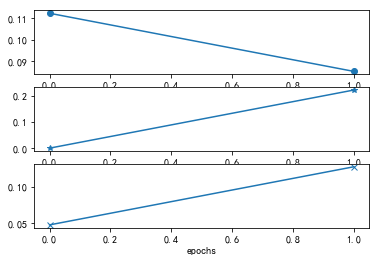

In [11]:
train(epochs=2,
		init_lr=0.001,
		lr_coefficient=5,
		weight_decay = 1e-8,
		model_num=1,
		batch_size=64,
		train_dir='s3://obs-garbageclassification/obs-dataset/mini_trail/',
		test_dir='s3://obs-garbageclassification/obs-dataset/mini_trail/',
		log_dir='s3://obs-garbageclassification/training_log/V0_0_3/',
		version = 'V0_0_3')